# Case study of the december 6 2021 storm melting layer in altitude


---

**Author**: Olivier Chalifour
**Organisation**: UQAM
**Date**: 26 July 2021

---

In [13]:
"""
Import
"""
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import os
import glob
import sys
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from sklearn.metrics import mean_squared_error
import scipy.stats
import math
import time as time_mod
import xarray as xr
sys.path.insert(0, "/home/chalifour/code/master")
import fct_script.rpn_funcs_chris as rpn_chris
from fct_script.get_domain import get_domain_info
from fct_script.func_py import get_colormap_precip,categorical_cmap
from matplotlib.patches import Patch
# from func_py import get_proj_extent

try:
    import rpnpy.librmn.all as rmn  # Module to read RPN files
    from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
except ImportError as err:
    print(f"RPNPY can only be use on the server. It can't be use on a personal computer."
          f"\nError throw :{err}")

In [26]:

# event 1
date_1 = '2021-11-17 23'
f_hr_1 = 30
datetimeobject_1 = datetime.strptime(date_1, '%Y-%m-%d %H')
new_format_1 = datetimeobject_1.strftime('%Y%m%d')
format_rpn_file_1 = datetimeobject_1.strftime('%Y%m')

run_1 = pd.Timestamp(fr'{date_1}')


valid_time_1 = run_1 + pd.Timedelta(str(f_hr_1) + ' h')
timestamps_1 = pd.date_range(run_1, valid_time_1, freq='1 H')
time_1 = timestamps_1

start_1 = run_1
end_1 = valid_time_1



# event 2
date_2 = '2021-12-06 05'
f_hr_2 = 30
datetimeobject_2 = datetime.strptime(date_2, '%Y-%m-%d %H')
new_format_2 = datetimeobject_2.strftime('%Y%m%d')
format_rpn_file_2 = datetimeobject_2.strftime('%Y%m')

run_2 = pd.Timestamp(fr'{date_2}')


valid_time_2 = run_2 + pd.Timedelta(str(f_hr_2) + ' h')
timestamps_2 = pd.date_range(run_2, valid_time_2, freq='1 H')
time_2 = timestamps_2

start_2 = run_2
end_2 = valid_time_2
#event 3

date_3 = '2022-03-06 06'
f_hr_3 = 30

datetimeobject_3 = datetime.strptime(date_3, '%Y-%m-%d %H')
new_format_3 = datetimeobject_3.strftime('%Y%m%d')
format_rpn_file_3 = datetimeobject_3.strftime('%Y%m')

run_3 = pd.Timestamp(fr'{date_3}')


valid_time_3 = run_3 + pd.Timedelta(str(f_hr_3) + ' h')
timestamps_3 = pd.date_range(run_3, valid_time_3, freq='1 H')
time_3 = timestamps_3

start_3 = run_3
end_3 = valid_time_3


timestamps_1_fig_minor = pd.date_range(run_1 + pd.Timedelta('1 h'), valid_time_1+ pd.Timedelta('6 h'), freq='6 H')
timestamps_1_fig_major = pd.date_range(run_1 - pd.Timedelta('23 h'), valid_time_1+ pd.Timedelta('1 h'), freq='24 H')[1:]
timestamps_2_fig_minor = pd.date_range(run_2 + pd.Timedelta('1 h'), valid_time_2+ pd.Timedelta('6 h'), freq='6 H')
timestamps_2_fig_major = pd.date_range(run_2 - pd.Timedelta('5 h'), valid_time_2+ pd.Timedelta('1 h'), freq='24 H')[1:]
timestamps_3_fig_minor = pd.date_range(run_3, valid_time_3 , freq='6 H')
timestamps_3_fig_major = pd.date_range(run_3 - pd.Timedelta('6 h'), valid_time_3+ pd.Timedelta('1 h'), freq='24 H')[1:]


In [15]:
# Simulation Data path

# path_dict_sim_11km = fr'/chinook/roberge/Output/GEM5/Olivier/NAM-11m_ERA5_GEM50_PCPTYPEnil'
# file_name_20211_11km = f'Samples/NAM-11m_ERA5_GEM50_PCPTYPEnil_{format_rpn_file}'
# path_202112_11km = [os.path.join(path_dict_sim_11km, file_name_20211_11km)]
# 
# path_dict_sim_2p5km = '/chinook/roberge/Output/GEM5/Olivier/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil'
# file_name_20211_2p5km = f'Samples/ECan_2.5km_NAM11mP3_GEM50_PCPTYPEnil_{format_rpn_file}'
# path_202112_2p5km = [os.path.join(path_dict_sim_2p5km, file_name_20211_2p5km)]



path_data_saving_1 = f"/upslope/chalifour/projet_maitrise/data_sim_station/data_alt_P3_{run_1.year}{run_1.month}"
path_data_saving_2 = f"/upslope/chalifour/projet_maitrise/data_sim_station/data_alt_P3_{run_2.year}{run_2.month}"
path_data_saving_3 = f"/upslope/chalifour/projet_maitrise/data_sim_station/data_alt_P3_{run_3.year}{run_3.month}"
# image output dir
image_output_dir = "/upslope/chalifour/projet_maitrise/fig/case_analysis"

# Important information
image_output_dpi = 150

# lat,lon station à étudier
lat_momo = 47.322437368331876
lon_momo = -71.14730110000002


In [16]:


def get_time_height(nc):
    time   = np.array(rpn_chris.dt64_to_datetime(nc.time))
    dt     = time[1]-time[0]
    height =  nc.height.data[0]/ 1000 + alt_radar # meters to kilometers

    # pas mal sure que ya un offset de 1.4km
    # height = nc.range.data / 1000 - 1.4  # meters to kilometers

    dh  = height[1]-height[0]


    return time,dt,height,dh

# Radar data at NEIGE

In [17]:
#event 1
path_data_1=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run_1.year}_{run_1.month}/master/FM_SN_MRR_MAS_21{run_1.month}1*[8-9].nc")
#event 2
path_data_2=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run_2.year}_{run_2.month}/master/FM_SN_MRR_MAS_21{run_2.month}0*[6-7].nc")
#event 3

path_data_3=glob.glob(f"/instruments/FORET_MONTMORENCY/Site_Neige/mrr/{run_3.year}_0{run_3.month}/master/FM_SN_MRR_MAS_220{run_3.month}0*[6-7].nc")

print(path_data_1)

['/instruments/FORET_MONTMORENCY/Site_Neige/mrr/2021_11/master/FM_SN_MRR_MAS_211118.nc', '/instruments/FORET_MONTMORENCY/Site_Neige/mrr/2021_11/master/FM_SN_MRR_MAS_211119.nc']


In [18]:
def get_melting_layer_altitude(ds,height,dh):
    ze = ds.Ze.T
    ze = np.ma.masked_invalid(ze)
    # gze = np.gradient(ze,dh_1,axis=0)
    
    idx_alt = np.nanargmax(ze,axis=0)
    
    altitude_melt = height[idx_alt]-dh/2
    
    # Iterate from the maximum reflectivity index downwards to find the melting layer
    
    # for i in range(np.shape(ze)[1]):
    #     mask_col = np.all(np.isnan(ze[:,i]), axis=0).values
    #     if mask_col:
    #         altitude_melt[i] = np.nan
            
    return altitude_melt


In [19]:
def detect_melting_layer(ze,height,dh,time, threshold=0.5):
    """
    Function to detect the melting layer in radar data.
    
    Parameters:
        dataframe (pandas.DataFrame): DataFrame containing radar data with time, altitude, and reflectivity columns.
        threshold (float): Threshold value to identify the melting layer.
        
    Returns:
        pandas.Series: Series containing melting altitudes indexed by time.
    """
    melting_altitudes = []
    
    for row in range(len(time)):
        reflectivity = ze[:,row]
        
        greflectivity = np.gradient(np.ma.masked_invalid(ze[:,row]),dh)
      
        # print(reflectivity)
        # print(greflectivity)
        if np.all(np.isnan(greflectivity)) or np.all(np.isnan(reflectivity)):
            melting_altitudes.append(np.nan)
        # elif np.mean(reflectivity)<threshold:
        #     melting_altitudes.append(np.nan)
        else:
            idxze_max = np.nanargmin(greflectivity)

            # Check if reflectivity exceeds threshold
            
            if np.isnan(reflectivity[idxze_max+1]):
                melting_altitudes.append(np.nan)
            elif idxze_max ==0:
                melting_altitudes.append(np.nan)
            elif np.isnan(reflectivity[idxze_max-1]):
                melting_altitudes.append(np.nan)
            elif np.sum(np.isnan(reflectivity))>= 0.6*len(reflectivity):
                melting_altitudes.append(np.nan)
                
            elif reflectivity[idxze_max] >= threshold:
                melting_altitudes.append(height[idxze_max]-dh/2) 
            else:
                melting_altitudes.append(np.nan)  # Assign NaN if reflectivity is below threshold

    melting_layerdf = pd.DataFrame({'time':time,'melting_layer':melting_altitudes})
    melting_layerdf.set_index('time',inplace=True)
    melting_layerdf.dropna(axis=0,inplace=True)
    melting_layerdf_h = melting_layerdf.resample('1H').mean()
    
    melting_layerdf_h.loc[melting_layerdf_h['melting_layer']>=3,'melting_layer'] = np.nan
    melting_layerdf_h.dropna(axis=0,inplace=True)
    melting_layer = melting_layerdf_h['melting_layer'].values
    time_rad = melting_layerdf_h.index
  
    # melting_layer[melting_layer >= 4] = np.nan
    # melting_layer = melting_layer[~np.isnan(melting_layer)] 
    # time_rad = time_rad[~np.isnan(melting_layer)] 
    return melting_layer,time_rad

# Example usage:
# Suppose you have a DataFrame named 'radar_data' with 'time', 'altitude', and 'reflectivity' columns
# You would call the function like this:
# melting_altitudes_series = detect_melting_layer(radar_data)

In [20]:
# def detect_melting_layer(ze,height,dh,time, window_size=5):
#     """
#     Function to detect the melting layer in radar data based on a decrease in reflectivity with height.
#     
#     Parameters:
#         altitude (numpy.ndarray): Array containing altitude data.
#         reflectivity (numpy.ndarray): Array containing reflectivity data.
#         window_size (int): Size of the window for computing the moving average of reflectivity.
#         
#     Returns:
#         numpy.ndarray: Array containing melting altitudes.
#     """
#     melting_altitudes = np.full_like(time, np.nan)
#     for row in range(len(time)):
#         reflectivity = ze[:,row]
#         # greflectivity = np.gradient(ze[:,row],dh)
#         if np.all(np.isnan(reflectivity)):
#             melting_altitudes[i] = np.nan
#         else:
#             for i in range(len(height)):
#                 if i >= window_size:
#                     avg_reflectivity = np.mean(reflectivity[i - window_size + 1:i + 1])
#                     if avg_reflectivity < reflectivity[i]:
#                         melting_altitudes[i] = height[i]-dh/2
#     
#     return melting_altitudes

In [21]:
# found in ds.properties
alt_radar = 664 /1000 # m->km
#event_1
nc_1 = []
for i in range(len(path_data_1)):
    nc_1.append(xr.open_dataset(path_data_1[i]))

nc_1 = xr.concat(nc_1, dim='time')

ds_1 = nc_1.sel(time=slice(str(start_1), str(end_1)))
# sigma_y = 3.0
# sigma_x = 2.0
# import scipy as sp
# import scipy.ndimage
# sigma = [sigma_y, sigma_x]

# ww = sp.ndimage.filters.gaussian_filter(ds_1.W.values, sigma, mode='constant')

time_rad_1, dt_1, height_1, dh_1 = get_time_height(ds_1)


melting_layer_1,time_rad_1 = detect_melting_layer(ds_1.W.T,height_1,dh_1,time_rad_1,4.5)


# def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='same')
#     return y_smooth

# melting_layer_1 = smooth(melting_layer_1,60)

In [22]:
#event_2
nc_2 = []
for i in range(len(path_data_2)):
    nc_2.append(xr.open_dataset(path_data_2[i]))

nc_2 = xr.concat(nc_2, dim='time')

ds_2 = nc_2.sel(time=slice(str(start_2), str(end_2)))

time_rad_2, dt_2, height_2, dh_2 = get_time_height(ds_2)

melting_layer_2,time_rad_2 = detect_melting_layer(ds_2.W.T,height_2,dh_2,time_rad_2,4.5)
print(melting_layer_2)


[1.81182609 1.70882763 1.52763637 1.38218179 1.37257139 1.36399996
 1.36399996]


In [23]:
#event_3
nc_3 = []
for i in range(len(path_data_3)):
    nc_3.append(xr.open_dataset(path_data_3[i]))

nc_3 = xr.concat(nc_3, dim='time')



ds_3 = nc_3.sel(time=slice(str(start_3), str(end_3)))

time_rad_3, dt_3, height_3, dh_3 = get_time_height(ds_3)

melting_layer_3,time_rad_3 = detect_melting_layer(ds_3.W.T,height_3,dh_3,time_rad_3,4.5)


# Figure

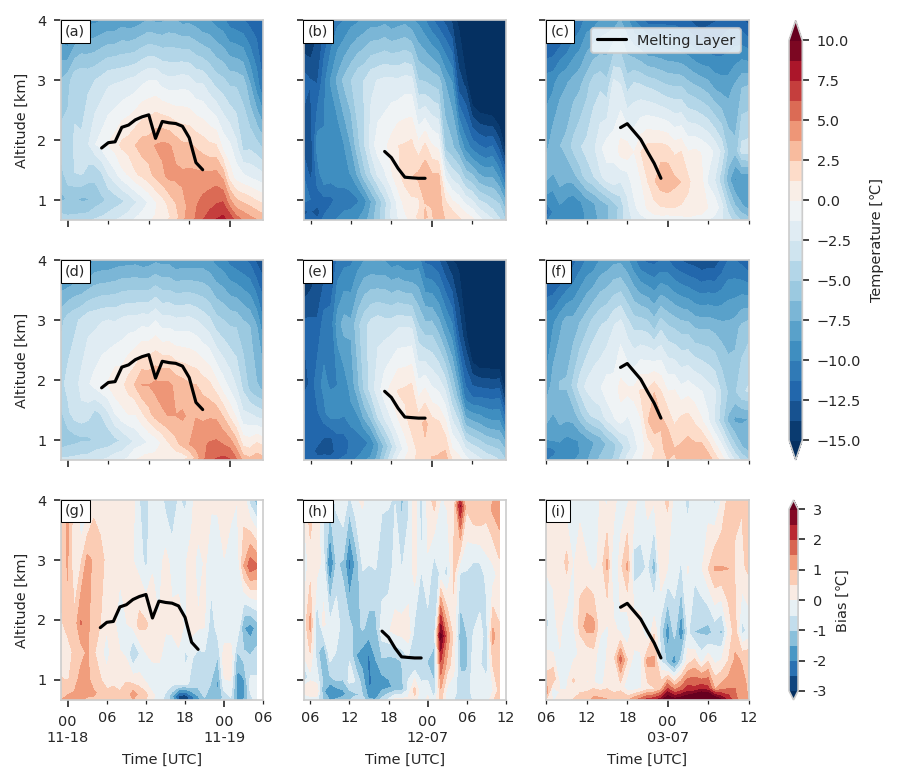

In [27]:
# Changer pour ne pas utiliser grid spec et utiliser des ax noral ça vas etre plus simple
pressure_level = [1000.,975.,950.,925.,900.,850.,800.,700.,600.,500.,400.,300.,250.,200.,150.,100.]
ymax=4
fig = plt.figure(facecolor='white',figsize = (8, 6),dpi=image_output_dpi)

spec = fig.add_gridspec(nrows=3,ncols=4,)

ax_1_11km = fig.add_subplot(spec[0,0])
ax_1_2p5km = fig.add_subplot(spec[1,0])
ax_1_diff = fig.add_subplot(spec[2,0])

ax_2_11km = fig.add_subplot(spec[0,1])
ax_2_2p5km = fig.add_subplot(spec[1,1])
ax_2_diff = fig.add_subplot(spec[2,1])

ax_3_11km = fig.add_subplot(spec[0,2])
ax_3_2p5km = fig.add_subplot(spec[1,2])
ax_3_diff = fig.add_subplot(spec[2,2])

cax_1 = fig.add_subplot(spec[0:2,3], aspect=30, anchor='W')
cax_2 = fig.add_subplot(spec[2,3], aspect=20, anchor='W')

list_axs=[ax_1_11km,ax_1_2p5km,ax_1_diff,ax_2_11km,ax_2_2p5km,ax_2_diff,ax_3_11km,ax_3_2p5km,ax_3_diff]

# ax.sharex([ax_1_11km,ax_1_2p5km,ax_1_diff])
for ax in [ax_1_11km,ax_1_2p5km,ax_1_diff]:
    # logic_array = ~(np.isnan(melting_layer_1))
    ax.plot(time_rad_1,melting_layer_1,label='Melting Layer',color='black')
    ax.set_xlim(time_1[0],time_1[-1])
    ax.tick_params(axis='y', which='major', labelsize='x-small')

for ax_2 in [ax_2_11km,ax_2_2p5km,ax_2_diff]:
    ax_2.plot(time_rad_2,melting_layer_2,label='Melting Layer',color='black')
    ax_2.set_xlim(time_2[0],time_2[-1])
    
for ax_3 in [ax_3_11km,ax_3_2p5km,ax_3_diff]:
    ax_3.plot(time_rad_3,melting_layer_3,label='Melting Layer',color='black')
    ax_3.set_xlim(time_3[0],time_3[-1])


bounds = np.arange(-15, 10 + 1.25, 1.25)
norm = TwoSlopeNorm(vmax=bounds[-1], vcenter=0, vmin=bounds[0])
reso='11km'
# plt temp 
path_TT_1_11km = os.path.join(path_data_saving_1,f'{reso}/TT.csv')
df_TT_1_11km= pd.read_csv(path_TT_1_11km,header=0,index_col=0, parse_dates=True)

path_gz_1_11km = os.path.join(path_data_saving_1,f'{reso}/GZ.csv')
df_gz_1_11km = pd.read_csv(path_gz_1_11km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_1,pressure_level)

cmap_temp = ax_1_11km.contourf(time_mesh,df_gz_1_11km.values.T,df_TT_1_11km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')


path_TT_2_11km = os.path.join(path_data_saving_2,f'{reso}/TT.csv')
df_TT_2_11km= pd.read_csv(path_TT_2_11km,header=0,index_col=0, parse_dates=True)

path_gz_2_11km = os.path.join(path_data_saving_2,f'{reso}/GZ.csv')
df_gz_2_11km = pd.read_csv(path_gz_1_11km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_2,pressure_level)
cmap_rain = ax_2_11km.contourf(time_mesh,df_gz_2_11km.values.T,df_TT_2_11km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')

path_TT_3_11km = os.path.join(path_data_saving_3,f'{reso}/TT.csv')
df_TT_3_11km = pd.read_csv(path_TT_3_11km,header=0,index_col=0, parse_dates=True)

path_gz_3_11km = os.path.join(path_data_saving_3,f'{reso}/GZ.csv')
df_gz_3_11km = pd.read_csv(path_gz_3_11km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_3,pressure_level)
cmap_rain = ax_3_11km.contourf(time_mesh,df_gz_3_11km.values.T,df_TT_3_11km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')

reso='2p5km'
# plt temp 
path_TT_1_2p5km = os.path.join(path_data_saving_1,f'{reso}/TT.csv')
df_TT_1_2p5km= pd.read_csv(path_TT_1_2p5km,header=0,index_col=0, parse_dates=True)

path_gz_1_2p5km = os.path.join(path_data_saving_1,f'{reso}/GZ.csv')
df_gz_1_2p5km = pd.read_csv(path_gz_1_2p5km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_1,pressure_level)
cmap_rain = ax_1_2p5km.contourf(time_mesh,df_gz_1_2p5km.values.T,df_TT_1_2p5km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')

path_TT_2_2p5km = os.path.join(path_data_saving_2,f'{reso}/TT.csv')
df_TT_2_2p5km= pd.read_csv(path_TT_2_2p5km,header=0,index_col=0, parse_dates=True)

path_gz_2_2p5km = os.path.join(path_data_saving_2,f'{reso}/GZ.csv')
df_gz_2_2p5km = pd.read_csv(path_gz_2_2p5km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_2,pressure_level)
cmap_rain = ax_2_2p5km.contourf(time_mesh,df_gz_2_2p5km.values.T,df_TT_2_2p5km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')

path_TT_3_2p5km = os.path.join(path_data_saving_3,f'{reso}/TT.csv')
df_TT_3_2p5km = pd.read_csv(path_TT_3_2p5km,header=0,index_col=0, parse_dates=True)

path_gz_3_2p5km = os.path.join(path_data_saving_3,f'{reso}/GZ.csv')
df_gz_3_2p5km = pd.read_csv(path_gz_3_2p5km,header=0,index_col=0, parse_dates=True)*10/1000

time_mesh,pres_mesh = np.meshgrid(time_3,pressure_level)
cmap_rain = ax_3_2p5km.contourf(time_mesh,df_gz_3_2p5km.values.T,df_TT_3_2p5km.values.T, cmap='RdBu_r',levels=bounds,norm=norm,extend='both')

#plot diff

# plt temp 

bounds_diff = np.arange(-3, 3 + 0.5, 0.5)
norm_diff = TwoSlopeNorm(vmax=bounds_diff[-1], vcenter=0, vmin=bounds_diff[0])
time_mesh,pres_mesh = np.meshgrid(time_1,pressure_level)
cmap_temp_diff = ax_1_diff.contourf(time_mesh,df_gz_1_2p5km.values.T,df_TT_1_2p5km.values.T-df_TT_1_11km.values.T, cmap='RdBu_r',levels=bounds_diff,norm=norm_diff,extend='both')

time_mesh_2,pres_mesh = np.meshgrid(time_2,pressure_level)
cmap_rain = ax_2_diff.contourf(time_mesh_2,df_gz_2_2p5km.values.T,df_TT_2_2p5km.values.T-df_TT_2_11km.values.T, cmap='RdBu_r',levels=bounds_diff,norm=norm_diff,extend='both')

time_mesh_3,pres_mesh = np.meshgrid(time_3,pressure_level)
cmap_rain = ax_3_diff.contourf(time_mesh_3,df_gz_3_2p5km.values.T,df_TT_3_2p5km.values.T-df_TT_3_11km.values.T, cmap='RdBu_r',levels=bounds_diff,norm=norm_diff,extend='both')

for ax in list_axs:
    # ax.set_aspect('equal')
    ax.sharey(list_axs[0])
    ax.grid(False)
    ax.set_ylim(alt_radar,ymax)
    ax.tick_params(axis='both',which="both",left=True,bottom=True)

ax_1_11km.set_ylabel('Altitude [km]', fontsize="x-small")
ax_1_2p5km.set_ylabel('Altitude [km]', fontsize="x-small")
ax_1_diff.set_ylabel('Altitude [km]', fontsize="x-small")

# ax_1_diff.xaxis.set_ticks(pd.date_range(time_1[0].date(), time_1[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
# ax_2_diff.xaxis.set_ticks(pd.date_range(time_2[0].date(), time_2[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
# ax_3_diff.xaxis.set_ticks(pd.date_range(time_3[0].date(), time_3[-1].date()+pd.Timedelta('1D'), freq = '12h'), minor=False)
# ax_1_diff.xaxis.set_ticks(pd.date_range(time_1[0].date(), time_1[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
# ax_2_diff.xaxis.set_ticks(pd.date_range(time_2[0].date(), time_2[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
# ax_3_diff.xaxis.set_ticks(pd.date_range(time_3[0].date(), time_3[-1].date()+pd.Timedelta('1D'), freq = '6h'), minor=True)
# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)

ax_1_11km.sharex(ax_1_diff)
ax_1_2p5km.sharex(ax_1_diff)
ax_1_diff.tick_params(which="both",bottom=True,labelbottom=True)
ax_1_diff.set_xlabel('Time [UTC]', fontsize='x-small')

ax_1_diff.set_xticks(timestamps_1_fig_minor, minor=True )
ax_1_diff.set_xticks(timestamps_1_fig_major, minor=False )

# ax_1_diff.xaxis.set_major_locator(locator_major)
# ax_1_diff.xaxis.set_minor_locator(locator_minor)
ax_1_diff.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_1_diff.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
ax_1_diff.tick_params(axis='x', which='major', labelsize='x-small')
ax_1_diff.tick_params(axis='x', which='minor', labelsize='x-small')
    
# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)
ax_2_11km.sharex(ax_2_diff)
ax_2_2p5km.sharex(ax_2_diff)
ax_2_diff.tick_params(which="both",bottom=True,labelbottom=True)
ax_2_diff.set_xlabel('Time [UTC]', fontsize='x-small')

ax_2_diff.set_xticks(timestamps_2_fig_minor, minor=True )
ax_2_diff.set_xticks(timestamps_2_fig_major, minor=False )

# ax_2_diff.xaxis.set_major_locator(locator_major)
# ax_2_diff.xaxis.set_minor_locator(locator_minor)
ax_2_diff.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_2_diff.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
ax_2_diff.tick_params(axis='x', which='major', labelsize='x-small')
ax_2_diff.tick_params(axis='x', which='minor', labelsize='x-small')
    
# locator_minor = mdates.HourLocator(interval=6)
# locator_major = mdates.HourLocator(interval=12)
ax_3_11km.sharex(ax_3_diff)
ax_3_2p5km.sharex(ax_3_diff)
ax_3_diff.tick_params(which="both",bottom=True,labelbottom=True)
ax_3_diff.set_xlabel('Time [UTC]', fontsize='x-small')

ax_3_diff.set_xticks(timestamps_3_fig_minor, minor=True )
ax_3_diff.set_xticks(timestamps_3_fig_major, minor=False )

# ax_3_diff.xaxis.set_major_locator(locator_major)
# ax_3_diff.xaxis.set_minor_locator(locator_minor)
ax_3_diff.xaxis.set_major_formatter(mdates.DateFormatter("%H\n%m-%d"))
ax_3_diff.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
ax_3_diff.tick_params(axis='x', which='major', labelsize='x-small')
ax_3_diff.tick_params(axis='x', which='minor', labelsize='x-small')

for ax in [ax_1_11km,ax_1_2p5km,ax_2_11km,ax_2_2p5km,ax_3_11km,ax_3_2p5km]:
    ax.tick_params(which="both",bottom=True,labelbottom=False)

for ax in [ax_2_11km,ax_2_2p5km,ax_2_diff,ax_3_11km,ax_3_2p5km,ax_3_diff]:
    ax.tick_params(which="both",left=True,labelleft=False)
# ax_1_11km.tick_params(axis='y', labelsize='x-small')
bounds_label = np.arange(bounds[0], bounds[-1] +1, 2.5)
cbar_num_format = "%d"
colorbar_temp = fig.colorbar(cmap_temp, cax=cax_1, ticks=bounds_label,
                                 orientation='vertical',shrink=0.6, aspect=30)
colorbar_temp.set_label('Temperature [\u2103]', fontsize='x-small')
colorbar_temp.ax.tick_params(labelsize='x-small')
    
bounds_diff = np.arange(bounds_diff[0], bounds_diff[-1] +1, 1)
colorbar_temp_diff = fig.colorbar(cmap_temp_diff, cax=cax_2,
                                 format=cbar_num_format, ticks=bounds_diff,
                                 orientation='vertical',shrink=0.6)

colorbar_temp_diff.set_label('Bias [\u2103]', fontsize='x-small')

colorbar_temp_diff.ax.tick_params(labelsize='x-small')
bbox = {'boxstyle':"square",'ec':'k' ,'fc':"w",'lw':0.5}
posi_text = (0.02, 0.98)
ax_1_11km.annotate('(a)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_2_11km.annotate('(b)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_3_11km.annotate('(c)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_1_2p5km.annotate('(d)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_2_2p5km.annotate('(e)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_3_2p5km.annotate('(f)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_1_diff.annotate('(g)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_2_diff.annotate('(h)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')
ax_3_diff.annotate('(i)',xy=posi_text, bbox=bbox, xycoords="axes fraction", ha='left',va='top',fontsize='x-small')

ax_3_11km.legend(fontsize='x-small',loc='upper right')

path_phase_fig = f'/upslope/chalifour/projet_maitrise/figure_final_submission/melting_layer_three_event.png'
fig.savefig(path_phase_fig, dpi=image_output_dpi, format='png' , bbox_inches='tight',) # Most backends support png, pdf,
plt.show()
